# Анализ датасета и тестирование DataLoader

В этом ноутбуке мы:
1. Инициализируем DataModule с большим текстовым датасетом
2. Проанализируем структуру и характеристики данных
3. Протестируем производительность DataLoader
4. Измерим потребление памяти

**Датасет:** AG News (120k новостных текстов, 4 класса)  
**Фичи:** TF-IDF + статистические признаки (размерность ~20k)  
**Хранение:** Memory-mapped файлы на диске (экономит RAM)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import time
import psutil
import os
from pathlib import Path

from text_features_data import TextFeaturesDataModule

sns.set_style('whitegrid')
%matplotlib inline

# Для отслеживания памяти
process = psutil.Process(os.getpid())


## 1. Инициализация DataModule

Создадим DataModule с большим текстовым датасетом.  
Данные будут храниться на диске в memory-mapped файлах и загружаться по требованию.


In [2]:
# Замеряем память ДО загрузки
mem_before = process.memory_info().rss / 1024 / 1024  # MB

print(f"Память до загрузки: {mem_before:.2f} MB\n")

# Создаем DataModule
dm = TextFeaturesDataModule(
    max_features=20000,  # размер словаря TF-IDF
    batch_size=128,
    use_bigrams=True,
    cache_dir="./cache",
)

print("Загружаем данные...")
start_time = time.time()
dm.prepare_data()
dm.setup()
load_time = time.time() - start_time

# Замеряем память ПОСЛЕ загрузки
mem_after = process.memory_info().rss / 1024 / 1024  # MB
mem_usage = mem_after - mem_before

print(f"\nВремя загрузки: {load_time:.2f} секунд")
print(f"Память после загрузки: {mem_after:.2f} MB")
print(f"Дополнительная память: {mem_usage:.2f} MB")


Память до загрузки: 667.38 MB

Загружаем данные...
Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140

Время загрузки: 3.88 секунд
Память после загрузки: 680.00 MB
Дополнительная память: 12.62 MB


## 2. Анализ структуры датасета


In [3]:
# Основная информация о датасете
print("=" * 60)
print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"Размерность входа: {dm.input_dim}")
print(f"Количество классов: {dm.n_classes}")
print(f"Train samples: {len(dm.train_dataset)}")
print(f"Val samples: {len(dm.val_dataset)}")
print(f"Batch size: {dm.batch_size}")
print("=" * 60)


ИНФОРМАЦИЯ О ДАТАСЕТЕ
Размерность входа: 20005
Количество классов: 4
Train samples: 108460
Val samples: 19140
Batch size: 128


In [4]:
# Проверяем батч данных
train_loader = dm.train_dataloader()
batch_X, batch_y = next(iter(train_loader))

print("\nПример батча:")
print(f"  X shape: {batch_X.shape} (batch_size, num_features)")
print(f"  y shape: {batch_y.shape}")
print(f"  X dtype: {batch_X.dtype}")
print(f"  y dtype: {batch_y.dtype}")
print(f"  X min: {batch_X.min():.4f}, max: {batch_X.max():.4f}")
print(f"  Классы в батче: {torch.unique(batch_y).tolist()}")



Пример батча:
  X shape: torch.Size([128, 20005]) (batch_size, num_features)
  y shape: torch.Size([128])
  X dtype: torch.float32
  y dtype: torch.int64
  X min: -2.3284, max: 7.7585
  Классы в батче: [0, 1, 2, 3]


/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/dl2025/lesson5/seminar/text_features_data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x = torch.FloatTensor(self.X[idx])


In [5]:
# Анализируем распределение классов
print("\nСобираем статистику по классам...")

# Собираем все метки
train_labels = []
for _, y in dm.train_dataloader():
    train_labels.extend(y.numpy())
train_labels = np.array(train_labels)

val_labels = []
for _, y in dm.val_dataloader():
    val_labels.extend(y.numpy())
val_labels = np.array(val_labels)

# Распределение классов
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)

print(f"\nРаспределение классов (train): {train_counts}")
print(f"Распределение классов (val): {val_counts}")

# Названия классов для AG News
class_names = ['Business', 'Sci/Tech', 'Sports', 'World']



Собираем статистику по классам...

Распределение классов (train): [27115 27115 27115 27115]
Распределение классов (val): [4785 4785 4785 4785]


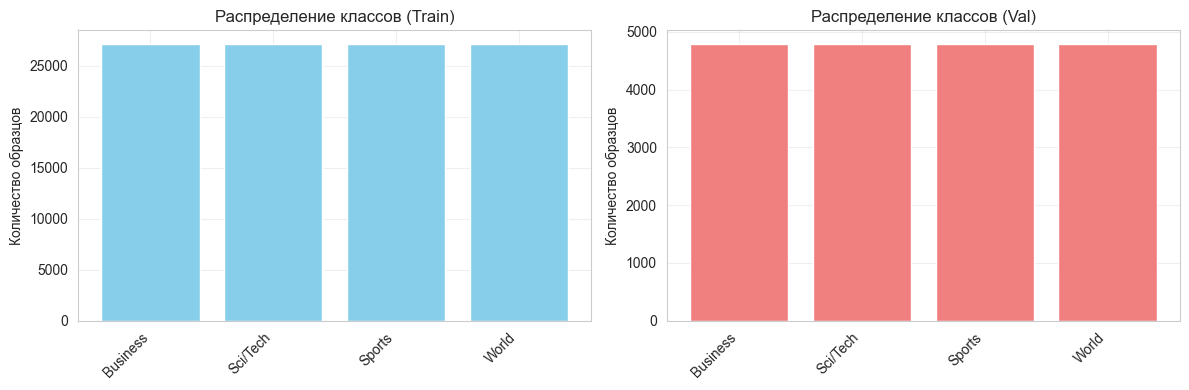


Дисбаланс классов (train): 1.00x
Дисбаланс классов (val): 1.00x


In [6]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train
axes[0].bar(range(len(train_counts)), train_counts, color='skyblue')
axes[0].set_xticks(range(len(train_counts)))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_ylabel('Количество образцов')
axes[0].set_title('Распределение классов (Train)')
axes[0].grid(True, alpha=0.3)

# Val
axes[1].bar(range(len(val_counts)), val_counts, color='lightcoral')
axes[1].set_xticks(range(len(val_counts)))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_ylabel('Количество образцов')
axes[1].set_title('Распределение классов (Val)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Проверяем баланс классов
balance_train = train_counts.max() / train_counts.min()
balance_val = val_counts.max() / val_counts.min()
print(f"\nДисбаланс классов (train): {balance_train:.2f}x")
print(f"Дисбаланс классов (val): {balance_val:.2f}x")


## 3. Тестирование производительности DataLoader

Проверим скорость загрузки данных из DataLoader.


In [7]:
def benchmark_dataloader(dataloader, num_batches=100, name="DataLoader"):
    """Тестирует скорость загрузки данных"""
    print(f"\n{name}:")
    print("-" * 40)
    
    batch_times = []
    total_samples = 0
    
    start_time = time.time()
    
    for i, (x, y) in enumerate(dataloader):
        if i >= num_batches:
            break
        
        batch_start = time.time()
        # Эмулируем обработку (перемещение на устройство)
        _ = x.shape
        _ = y.shape
        batch_time = time.time() - batch_start
        
        batch_times.append(batch_time)
        total_samples += len(x)
    
    total_time = time.time() - start_time
    
    # Статистика
    avg_batch_time = np.mean(batch_times)
    std_batch_time = np.std(batch_times)
    throughput = total_samples / total_time
    
    print(f"Обработано батчей: {len(batch_times)}")
    print(f"Всего образцов: {total_samples}")
    print(f"Общее время: {total_time:.3f} сек")
    print(f"Среднее время на батч: {avg_batch_time*1000:.2f} ± {std_batch_time*1000:.2f} ms")
    print(f"Throughput: {throughput:.0f} samples/sec")
    
    return {
        'avg_time': avg_batch_time,
        'std_time': std_batch_time,
        'throughput': throughput,
        'total_time': total_time,
    }


In [8]:
# Тестируем DataLoader (без num_workers)
print("="*60)
print("ТЕСТ 1: Baseline (num_workers=0)")
print("="*60)

train_loader_baseline = dm.train_dataloader()
results_baseline = benchmark_dataloader(train_loader_baseline, num_batches=100, name="Baseline DataLoader")


ТЕСТ 1: Baseline (num_workers=0)

Baseline DataLoader:
----------------------------------------
Обработано батчей: 100
Всего образцов: 12800
Общее время: 0.863 сек
Среднее время на батч: 0.00 ± 0.00 ms
Throughput: 14828 samples/sec


## 4. Тестирование с num_workers

Проверим, как влияет количество workers на производительность DataLoader.


In [9]:
# Тестируем разное количество workers
num_workers_list = [0, 2, 4]
results_workers = {}

print("="*60)
print("ТЕСТ: влияние num_workers")
print("="*60)

for num_workers in num_workers_list:
    print(f"\n--- num_workers={num_workers} ---")
    
    # Создаем DataModule с нужным числом workers
    dm_test = TextFeaturesDataModule(
        max_features=20000,
        batch_size=128,
        use_bigrams=True,
        cache_dir="./cache",
        num_workers=num_workers,
    )
    dm_test.setup()
    
    # Тестируем
    test_loader = dm_test.train_dataloader()
    results = benchmark_dataloader(test_loader, num_batches=100, name=f"workers={num_workers}")
    results_workers[num_workers] = results


ТЕСТ: влияние num_workers

--- num_workers=0 ---
Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140

workers=0:
----------------------------------------
Обработано батчей: 100
Всего образцов: 12800
Общее время: 1.002 сек
Среднее время на батч: 0.00 ± 0.00 ms
Throughput: 12777 samples/sec

--- num_workers=2 ---
Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140

workers=2:
----------------------------------------
Обработано батчей: 100
Всего образцов: 12800
Общее время: 0.801 сек
Среднее время на батч: 0.00 ± 0.00 ms
Throughput: 15980 samples/sec

--- num_workers=4 ---
Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140

workers=4:
----------------------------------------
Обработано батчей: 100
Всего образцов: 12800
Общее время: 0.484 сек
Среднее время на батч: 0.00 ± 0.00 ms
Throughput: 26428 samples/sec


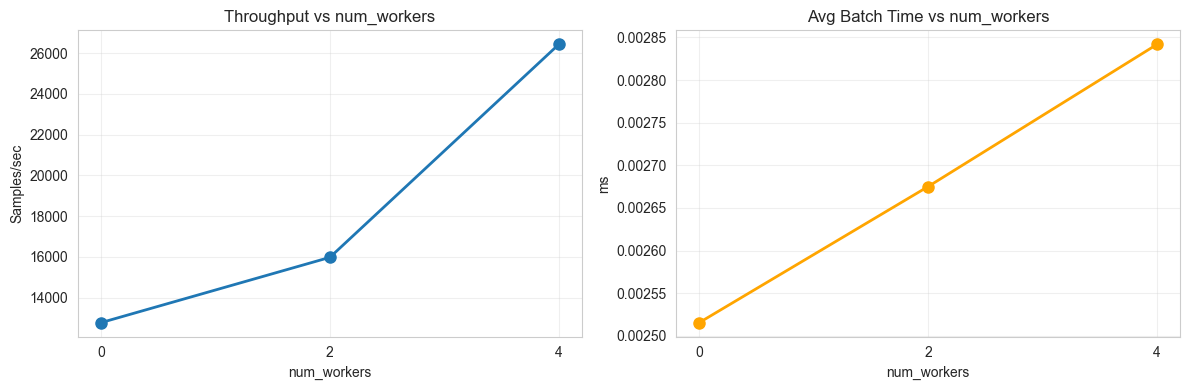


Лучший результат: num_workers=4
Throughput: 26428 samples/sec
Speedup vs num_workers=0: 2.07x


In [10]:
# Визуализация влияния num_workers
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

workers = list(results_workers.keys())
throughputs_workers = [results_workers[w]['throughput'] for w in workers]
batch_times_workers = [results_workers[w]['avg_time']*1000 for w in workers]

# Throughput
axes[0].plot(workers, throughputs_workers, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('num_workers')
axes[0].set_ylabel('Samples/sec')
axes[0].set_title('Throughput vs num_workers')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(workers)

# Batch time
axes[1].plot(workers, batch_times_workers, marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('num_workers')
axes[1].set_ylabel('ms')
axes[1].set_title('Avg Batch Time vs num_workers')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(workers)

plt.tight_layout()
plt.show()

# Лучшая конфигурация
best_workers = max(results_workers.keys(), key=lambda w: results_workers[w]['throughput'])
print(f"\nЛучший результат: num_workers={best_workers}")
print(f"Throughput: {results_workers[best_workers]['throughput']:.0f} samples/sec")
print(f"Speedup vs num_workers=0: {results_workers[best_workers]['throughput'] / results_workers[0]['throughput']:.2f}x")


## 5. Размер файлов на диске

Посмотрим, сколько места занимают данные на диске.


In [14]:
# Проверяем размер файлов
cache_dir = Path("./cache")

if cache_dir.exists():
    print("Файлы в кеше:")
    print("-" * 60)
    
    total_size = 0
    files_info = []
    
    for file_path in sorted(cache_dir.glob("*")):
        if file_path.is_file():
            size_bytes = file_path.stat().st_size
            size_mb = size_bytes / 1024 / 1024
            total_size += size_mb
            
            files_info.append({
                'Файл': file_path.name,
                'Размер (MB)': f'{size_mb:.2f}'
            })
    
    df_files = pd.DataFrame(files_info)
    print(df_files.to_string(index=False))
    
    print("-" * 60)
    print(f"Общий размер: {total_size:.2f} MB")
else:
    print("Кеш директория не найдена")


Файлы в кеше:
------------------------------------------------------------
                                Файл Размер (MB)
   ag_news_train_bigrams_20000_X.npy    16553.82
ag_news_train_bigrams_20000_meta.pkl        0.74
   ag_news_train_bigrams_20000_y.npy        0.83
     ag_news_val_bigrams_20000_X.npy     2921.26
     ag_news_val_bigrams_20000_y.npy        0.15
------------------------------------------------------------
Общий размер: 19476.80 MB
